In [2]:
import sys, os
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator
import os.path
import pandas as pd

PATH=os.path.expanduser("~/h2o-3/")
h2o.init(nthreads=-1)
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,14 mins 26 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,7 hours and 20 minutes
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.66 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


https://research.googleblog.com/2016/08/improving-inception-and-image.html

![inception_resnet_v2](images/inception-resnetv2.png)

In [3]:
def Conv(data, num_filter, kernel=(1, 1), stride=(1, 1), pad=(0, 0), name=None, suffix='', withRelu=True, withBn=False):
    import mxnet as mx
    conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel, stride=stride, pad=pad,
                              name='%s%s_conv2d' % (name, suffix))
    if withBn:
        conv = mx.sym.BatchNorm(data=conv, name='%s%s_bn' % (name, suffix))
    if withRelu:
        conv = mx.sym.Activation(data=conv, act_type='relu', name='%s%s_relu' % (name, suffix))
    return conv


# Input Shape is 3*299*299 (th)
def InceptionResnetStem(data,
                        num_1_1, num_1_2, num_1_3,
                        num_2_1,
                        num_3_1, num_3_2,
                        num_4_1, num_4_2, num_4_3, num_4_4,
                        num_5_1,
                        name):
    import mxnet as mx
    stem_3x3 = Conv(data=data, num_filter=num_1_1, kernel=(3, 3), stride=(2, 2), name=('%s_conv' % name))
    stem_3x3 = Conv(data=stem_3x3, num_filter=num_1_2, kernel=(3, 3), name=('%s_stem' % name), suffix='_conv')
    stem_3x3 = Conv(data=stem_3x3, num_filter=num_1_3, kernel=(3, 3), pad=(1, 1), name=('%s_stem' % name),
                    suffix='_conv_1')

    pool1 = mx.sym.Pooling(data=stem_3x3, kernel=(3, 3), stride=(2, 2), pool_type='max',
                           name=('%s_%s_pool1' % ('max', name)))
    stem_1_3x3 = Conv(data=stem_3x3, num_filter=num_2_1, kernel=(3, 3), stride=(2, 2), name=('%s_stem_1' % name),
                      suffix='_conv_1')

    concat1 = mx.sym.Concat(*[pool1, stem_1_3x3], name=('%s_concat_1' % name))

    stem_1_1x1 = Conv(data=concat1, num_filter=num_3_1, name=('%s_stem_1' % name), suffix='_conv_2')
    stem_1_3x3 = Conv(data=stem_1_1x1, num_filter=num_3_2, kernel=(3, 3), name=('%s_stem_1' % name), suffix='_conv_3')

    stem_2_1x1 = Conv(data=concat1, num_filter=num_4_1, name=('%s_stem_2' % name), suffix='_conv_1')
    stem_2_7x1 = Conv(data=stem_2_1x1, num_filter=num_4_2, kernel=(7, 1), pad=(3, 0), name=('%s_stem_2' % name),
                      suffix='_conv_2')
    stem_2_1x7 = Conv(data=stem_2_7x1, num_filter=num_4_3, kernel=(1, 7), pad=(0, 3), name=('%s_stem_2' % name),
                      suffix='_conv_3')
    stem_2_3x3 = Conv(data=stem_2_1x7, num_filter=num_4_4, kernel=(3, 3), name=('%s_stem_2' % name), suffix='_conv_4')

    concat2 = mx.sym.Concat(*[stem_1_3x3, stem_2_3x3], name=('%s_concat_2' % name))

    pool2 = mx.sym.Pooling(data=concat2, kernel=(3, 3), stride=(2, 2), pool_type='max',
                           name=('%s_%s_pool2' % ('max', name)))
    stem_3_3x3 = Conv(data=concat2, num_filter=num_5_1, kernel=(3, 3), stride=(2, 2), name=('%s_stem_3' % name),
                      suffix='_conv_1', withRelu=False)

    concat3 = mx.sym.Concat(*[pool2, stem_3_3x3], name=('%s_concat_3' % name))
    bn1 = mx.sym.BatchNorm(data=concat3, name=('%s_bn1' % name))
    act1 = mx.sym.Activation(data=bn1, act_type='relu', name=('%s_relu1' % name))

    return act1

def InceptionResnetV2A(data,
                       num_1_1,
                       num_2_1, num_2_2,
                       num_3_1, num_3_2, num_3_3,
                       proj,
                       name,
                       scaleResidual=True):
    import mxnet as mx
    init = data

    a1 = Conv(data=data, num_filter=num_1_1, name=('%s_a_1' % name), suffix='_conv')

    a2 = Conv(data=data, num_filter=num_2_1, name=('%s_a_2' % name), suffix='_conv_1')
    a2 = Conv(data=a2, num_filter=num_2_2, kernel=(3, 3), pad=(1, 1), name=('%s_a_2' % name), suffix='_conv_2')

    a3 = Conv(data=data, num_filter=num_3_1, name=('%s_a_3' % name), suffix='_conv_1')
    a3 = Conv(data=a3, num_filter=num_3_2, kernel=(3, 3), pad=(1, 1), name=('%s_a_3' % name), suffix='_conv_2')
    a3 = Conv(data=a3, num_filter=num_3_3, kernel=(3, 3), pad=(1, 1), name=('%s_a_3' % name), suffix='_conv_3')

    merge = mx.sym.Concat(*[a1, a2, a3], name=('%s_a_concat1' % name))

    conv = Conv(data=merge, num_filter=proj, name=('%s_a_liner_conv' % name), withRelu=False)
    if scaleResidual:
        conv *= 0.1

    out = init + conv
    bn = mx.sym.BatchNorm(data=out, name=('%s_a_bn1' % name))
    act = mx.sym.Activation(data=bn, act_type='relu', name=('%s_a_relu1' % name))

    return act


def InceptionResnetV2B(data,
                       num_1_1,
                       num_2_1, num_2_2, num_2_3,
                       proj,
                       name,
                       scaleResidual=True):
    import mxnet as mx
    init = data

    b1 = Conv(data=data, num_filter=num_1_1, name=('%s_b_1' % name), suffix='_conv')

    b2 = Conv(data=data, num_filter=num_2_1, name=('%s_b_2' % name), suffix='_conv_1')
    b2 = Conv(data=b2, num_filter=num_2_2, kernel=(1, 7), pad=(0, 3), name=('%s_b_2' % name), suffix='_conv_2')
    b2 = Conv(data=b2, num_filter=num_2_3, kernel=(7, 1), pad=(3, 0), name=('%s_b_2' % name), suffix='_conv_3')

    merge = mx.sym.Concat(*[b1, b2], name=('%s_b_concat1' % name))

    conv = Conv(data=merge, num_filter=proj, name=('%s_b_liner_conv' % name), withRelu=False)
    if scaleResidual:
        conv *= 0.1

    out = init + conv
    bn = mx.sym.BatchNorm(data=out, name=('%s_b_bn1' % name))
    act = mx.sym.Activation(data=bn, act_type='relu', name=('%s_b_relu1' % name))

    return act


def InceptionResnetV2C(data,
                       num_1_1,
                       num_2_1, num_2_2, num_2_3,
                       proj,
                       name,
                       scaleResidual=True):
    import mxnet as mx
    init = data

    c1 = Conv(data=data, num_filter=num_1_1, name=('%s_c_1' % name), suffix='_conv')

    c2 = Conv(data=data, num_filter=num_2_1, name=('%s_c_2' % name), suffix='_conv_1')
    c2 = Conv(data=c2, num_filter=num_2_2, kernel=(1, 3), pad=(0, 1), name=('%s_c_2' % name), suffix='_conv_2')
    c2 = Conv(data=c2, num_filter=num_2_3, kernel=(3, 1), pad=(1, 0), name=('%s_c_2' % name), suffix='_conv_3')

    merge = mx.sym.Concat(*[c1, c2], name=('%s_c_concat1' % name))

    conv = Conv(data=merge, num_filter=proj, name=('%s_b_liner_conv' % name), withRelu=False)
    if scaleResidual:
        conv *= 0.1

    out = init + conv
    bn = mx.sym.BatchNorm(data=out, name=('%s_c_bn1' % name))
    act = mx.sym.Activation(data=bn, act_type='relu', name=('%s_c_relu1' % name))

    return act


def ReductionResnetV2A(data,
                       num_2_1,
                       num_3_1, num_3_2, num_3_3,
                       name):
    import mxnet as mx
    ra1 = mx.sym.Pooling(data=data, kernel=(3, 3), stride=(2, 2), pool_type='max', name=('%s_%s_pool1' % ('max', name)))

    ra2 = Conv(data=data, num_filter=num_2_1, kernel=(3, 3), stride=(2, 2), name=('%s_ra_2' % name), suffix='_conv', withRelu=False)

    ra3 = Conv(data=data, num_filter=num_3_1, name=('%s_ra_3' % name), suffix='_conv_1')
    ra3 = Conv(data=ra3, num_filter=num_3_2, kernel=(3, 3), pad=(1, 1), name=('%s_ra_3' % name), suffix='_conv_2')
    ra3 = Conv(data=ra3, num_filter=num_3_3, kernel=(3, 3), stride=(2, 2), name=('%s_ra_3' % name), suffix='_conv_3', withRelu=False)

    m = mx.sym.Concat(*[ra1, ra2, ra3], name=('%s_ra_concat1' % name))
    m = mx.sym.BatchNorm(data=m, name=('%s_ra_bn1' % name))
    m = mx.sym.Activation(data=m, act_type='relu', name=('%s_ra_relu1' % name))

    return m


def ReductionResnetV2B(data,
                       num_2_1, num_2_2,
                       num_3_1, num_3_2,
                       num_4_1, num_4_2, num_4_3,
                       name):
    import mxnet as mx
    rb1 = mx.sym.Pooling(data=data, kernel=(3, 3), stride=(2, 2), pool_type='max', name=('%s_%s_pool1' % ('max', name)))

    rb2 = Conv(data=data, num_filter=num_2_1, name=('%s_rb_2' % name), suffix='_conv_1')
    rb2 = Conv(data=rb2, num_filter=num_2_2, kernel=(3, 3), stride=(2, 2), name=('%s_rb_2' % name), suffix='_conv_2', withRelu=False)

    rb3 = Conv(data=data, num_filter=num_3_1, name=('%s_rb_3' % name), suffix='_conv_1')
    rb3 = Conv(data=rb3, num_filter=num_3_2, kernel=(3, 3), stride=(2, 2), name=('%s_rb_3' % name), suffix='_conv_2', withRelu=False)

    rb4 = Conv(data=data, num_filter=num_4_1, name=('%s_rb_4' % name), suffix='_conv_1')
    rb4 = Conv(data=rb4, num_filter=num_4_2, kernel=(3, 3), pad=(1, 1), name=('%s_rb_4' % name), suffix='_conv_2')
    rb4 = Conv(data=rb4, num_filter=num_4_3, kernel=(3, 3), stride=(2, 2), name=('%s_rb_4' % name), suffix='_conv_3', withRelu=False)

    m = mx.sym.Concat(*[rb1, rb2, rb3, rb4], name=('%s_rb_concat1' % name))
    m = mx.sym.BatchNorm(data=m, name=('%s_rb_bn1' % name))
    m = mx.sym.Activation(data=m, act_type='relu', name=('%s_rb_relu1' % name))

    return m


def circle_in3a(data,
                num_1_1,
                num_2_1, num_2_2,
                num_3_1, num_3_2, num_3_3,
                proj,
                name,
                scale,
                round):
    in3a = data
    for i in xrange(round):
        in3a = InceptionResnetV2A(in3a,
                                  num_1_1,
                                  num_2_1, num_2_2,
                                  num_3_1, num_3_2, num_3_3,
                                  proj,
                                  name + ('_%d' % i),
                                  scaleResidual=scale)
    return in3a


def circle_in2b(data,
                num_1_1,
                num_2_1, num_2_2, num_2_3,
                proj,
                name,
                scale,
                round):
    in2b = data
    for i in xrange(round):
        in2b = InceptionResnetV2B(in2b,
                                  num_1_1,
                                  num_2_1, num_2_2, num_2_3,
                                  proj,
                                  name + ('_%d' % i),
                                  scaleResidual=scale)
    return in2b


def circle_in2c(data,
                num_1_1,
                num_2_1, num_2_2, num_2_3,
                proj,
                name,
                scale,
                round):
    in2c = data
    for i in xrange(round):
        in2c = InceptionResnetV2C(in2c,
                                  num_1_1,
                                  num_2_1, num_2_2, num_2_3,
                                  proj,
                                  name + ('_%d' % i),
                                  scaleResidual=scale)
    return in2c


# create inception-resnet-v2
def get_symbol(num_classes=1000, scale=True):
    import mxnet as mx
    # input shape 3*229*229
    data = mx.symbol.Variable(name="data")

    # stage stem
    (num_1_1, num_1_2, num_1_3) = (32, 32, 64)
    num_2_1 = 96
    (num_3_1, num_3_2) = (64, 96)
    (num_4_1, num_4_2, num_4_3, num_4_4) = (64, 64, 64, 96)
    num_5_1 = 192

    in_stem = InceptionResnetStem(data,
                                  num_1_1, num_1_2, num_1_3,
                                  num_2_1,
                                  num_3_1, num_3_2,
                                  num_4_1, num_4_2, num_4_3, num_4_4,
                                  num_5_1,
                                  'stem_stage')

    # stage 5 x Inception Resnet A
    num_1_1 = 32
    (num_2_1, num_2_2) = (32, 32)
    (num_3_1, num_3_2, num_3_3) = (32, 48, 64)
    proj = 384

    in3a = circle_in3a(in_stem,
                       num_1_1,
                       num_2_1, num_2_2,
                       num_3_1, num_3_2, num_3_3,
                       proj,
                       'in3a',
                       scale,
                       5)
    # stage Reduction Resnet A
    num_1_1 = 384
    (num_2_1, num_2_2, num_2_3) = (256, 256, 384)

    re3a = ReductionResnetV2A(in3a,
                              num_1_1,
                              num_2_1, num_2_2, num_2_3,
                              're3a')

    # stage 10 x Inception Resnet B
    num_1_1 = 192
    (num_2_1, num_2_2, num_2_3) = (128, 160, 192)
    proj = 1152

    in2b = circle_in2b(re3a,
                       num_1_1,
                       num_2_1, num_2_2, num_2_3,
                       proj,
                       'in2b',
                       scale,
                       10)

    # stage ReductionB
    (num_1_1, num_1_2) = (256, 384)
    (num_2_1, num_2_2) = (256, 288)
    (num_3_1, num_3_2, num_3_3) = (256, 288, 320)

    re4b = ReductionResnetV2B(in2b,
                              num_1_1, num_1_2,
                              num_2_1, num_2_2,
                              num_3_1, num_3_2, num_3_3,
                              're4b')

    # stage 5 x Inception Resnet C
    num_1_1 = 192
    (num_2_1, num_2_2, num_2_3) = (192, 224, 256)
    proj = 2144

    in2c = circle_in2c(re4b,
                       num_1_1,
                       num_2_1, num_2_2, num_2_3,
                       proj,
                       'in2c',
                       scale,
                       5)

    # stage Average Poolingact1
    pool = mx.sym.Pooling(data=in2c, kernel=(8, 8), stride=(1, 1), pool_type="avg", name="global_pool")

    # stage Dropout
    dropout = mx.sym.Dropout(data=pool, p=0.2)
    # dropout =  mx.sym.Dropout(data=pool, p=0.8)
    flatten = mx.sym.Flatten(data=dropout, name="flatten")

    # output
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=num_classes, name='fc1')
    softmax = mx.symbol.SoftmaxOutput(data=fc1, name='softmax')
    return softmax

In [13]:
frame = h2o.import_file(PATH+"/bigdata/laptop/deepwater/imagenet/cat_dog_mouse.csv")
print(frame.head(5))

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


C1,C2
bigdata/laptop/deepwater/imagenet/cat/102194502_49f003abd9.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/11146807_00a5f35255.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/1140846215_70e326f868.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/114170569_6cbdf4bbdb.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/1217664848_de4c7fc296.jpg,cat


['bigdata/laptop/deepwater/imagenet/cat/385411257_e7d9d37476.jpg', 'bigdata/laptop/deepwater/imagenet/cat/140927280_7f06e7d500.jpg', 'bigdata/laptop/deepwater/imagenet/cat/2176140947_59b760a11c.jpg', 'bigdata/laptop/deepwater/imagenet/dog/2800688_afe83c164a.jpg', 'bigdata/laptop/deepwater/imagenet/cat/1388193613_06f57b76ff.jpg']


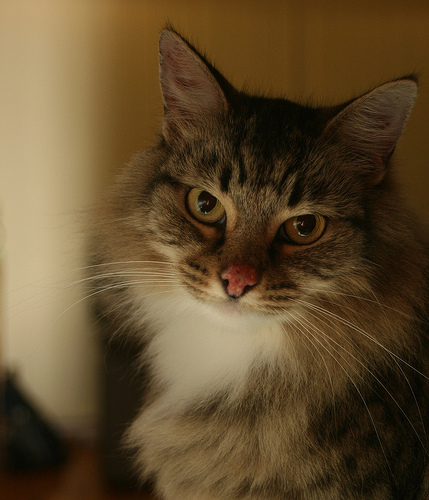

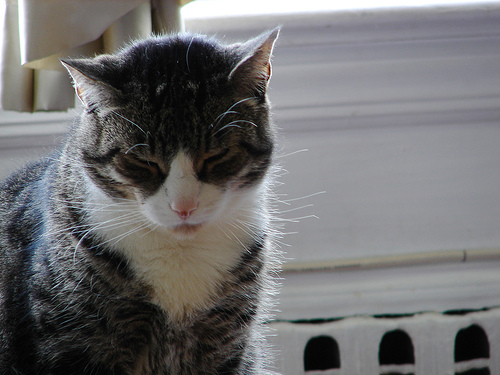

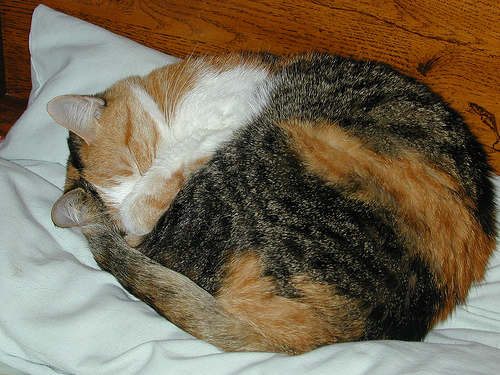

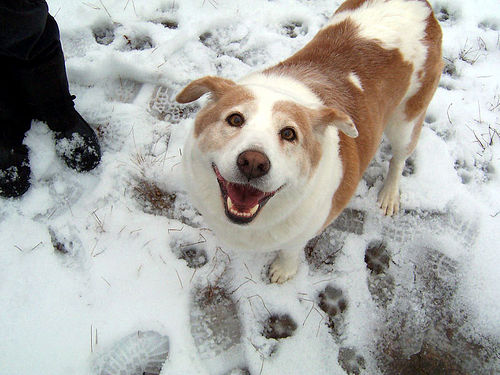

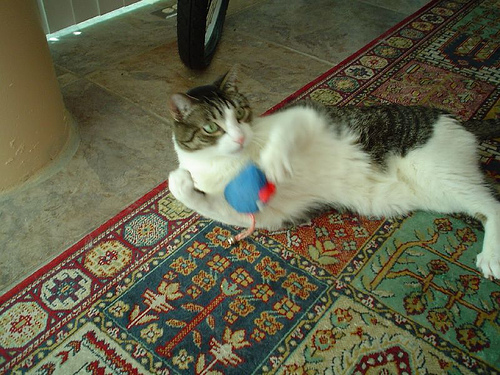

In [132]:
from IPython.display import Image, display, HTML
import pandas as pd
import random
images = frame[:,0].as_data_frame(use_pandas=False)
which=list(random.sample(xrange(frame.nrow), 5))
print([images[i][0] for i in which])
random5 = [images[x][0] for x in which]
#random
for x in random5:
    display(Image(filename=PATH+x))

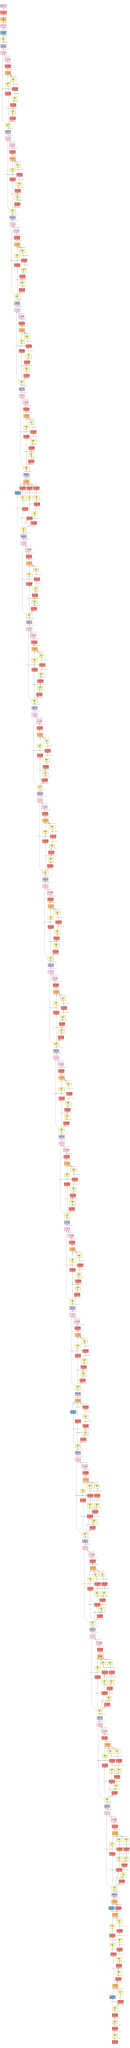

In [4]:
# pip install graphviz
# sudo apt-get install graphviz
import mxnet as mx
import graphviz
mx.viz.plot_network(get_symbol(3), shape={"data":(1, 3, 299, 299)}, node_attrs={"shape":'rect',"fixedsize":'false'})

In [10]:
nclasses = frame[1].nlevels()[0]

# Creating the model architecture from scratch using the MXNet Python API
get_symbol(nclasses).save("/tmp/symbol_inception_resnet_v2-py.json")
model = H2ODeepWaterEstimator(epochs=20, #learning_rate=1e-3, learning_rate_annealing=1e-5,
                              mini_batch_size=16,
                              ## provide network specific information
                              network_definition_file="/tmp/symbol_inception_resnet_v2-py.json",
                              image_shape=[299,299],
                              channels=3)

model.train(x=[0],y=1, training_frame=frame)
model.show()
error = model.model_performance(train=True).mean_per_class_error()

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%
Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477179782032_5
Status of Deep Learning Model: user, 116.1 MB, predicting C2, 3-class classification, 5,632 training samples, mini-batch size 16



,input_neurons,rate,momentum
,268203,0.0049720,0.950688




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.22905755098
RMSE: 0.478599572691
LogLoss: 0.901201192238
Mean Per-Class Error: 0.277398882258
Confusion Matrix: vertical: actual; across: predicted



cat,dog,mouse,Error,Rate
52.0,2.0,36.0,0.4222222,38 / 90
5.0,52.0,28.0,0.3882353,33 / 85
1.0,1.0,90.0,0.0217391,2 / 92
58.0,55.0,154.0,0.2734082,73 / 267


Top-3 Hit Ratios: 


k,hit_ratio
1,0.7265918
2,0.9475656
3,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-22 17:12:42,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-22 17:12:52,12.046 sec,50 obs/sec,1.9176030,1,512.0,0.7733955,5.8261166,0.6479401
,2016-10-22 17:13:14,34.095 sec,49 obs/sec,5.7528090,3,1536.0,0.7943495,12.6718789,0.6479401
,2016-10-22 17:13:37,56.281 sec,49 obs/sec,9.5880150,5,2560.0,0.7892767,4.9085502,0.6704120
,2016-10-22 17:13:59,1 min 18.631 sec,49 obs/sec,13.4232210,7,3584.0,0.5675845,1.1125670,0.4119850
,2016-10-22 17:14:22,1 min 41.296 sec,49 obs/sec,17.2584270,9,4608.0,0.6654301,1.7466571,0.5842697
,2016-10-22 17:14:43,2 min 3.069 sec,49 obs/sec,21.0936330,11,5632.0,0.4785996,0.9012012,0.2734082
